# Self-organinzing (Kohonen) map

[Self-organizing maps](https://en.wikipedia.org/wiki/Self-organizing_map) find a low-dimensional (in this case 2) embedding of their inputs such that nearby spatial locations have similar tuning. They were originally put forth as a model for sparse tuning (only the neuron/2D location that matches best is activated), and topographic maps like the feature (orientation) maps in the retina or the sensory/motor homunculus. [Neuronal Dynamics §16.3.4 Formal winner-take-all networks](https://neuronaldynamics.epfl.ch/online/Ch16.S3.html) is also relevant.

In the code below 

 1. Which operation corresponds to Hebbian-style learning?
 2. Which operation provides the equivalent of homeostasis to stabilize Hebbian learning?
 3. The 2D unit layout is a patch of cortex. What does the parameter $\sigma$ correspond to? What happens when it it too small/large? Why do we gradually decrease it over learning in this demo?

100%|█████████████████████████████████| 20/20 [00:21<00:00,  1.10s/it]


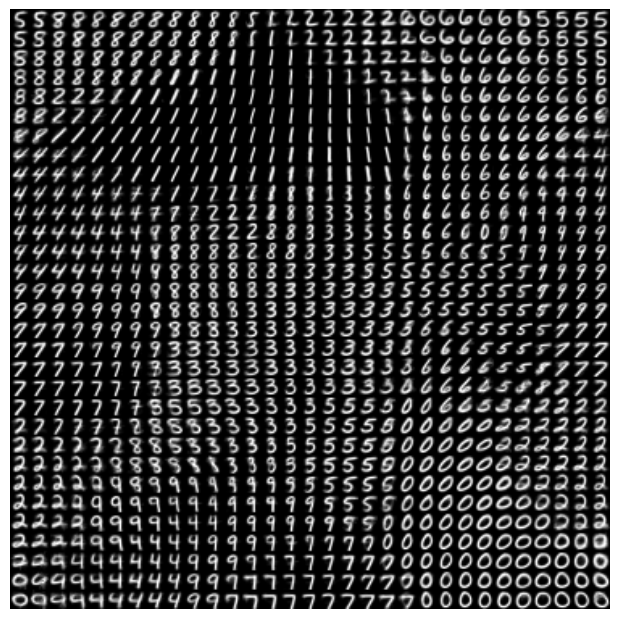

In [1]:
from pylab import *
from tqdm  import tqdm
from scipy.linalg  import expm
from scipy.special import softmax

# makes (list of) vectors unit length
def normalize(Q,reg=1e-6):
    return Q/(reg+norm(Q,2,axis=-1)[:,None])

L = 12 # L×L image patches 
K = 31 # K×K Map size

# Load saved MNIST, trimmed down for speed
Y = normalize(np.load("./micronist.npz")['xtrain'].T)
assert Y.shape[1]==L*L

# Define adjacent areas
adjacency = eye(K**2,k=1) + eye(K**2,k=-1) + eye(K**2,k=K) + eye(K**2,k=-K)
laplacian = adjacency - diag(sum(adjacency,0))

# Initialize random weights
W = normalize(randn(K**2,L**2)**2)

# Train
radii = 2**linspace(3,-3,20)
for i,σ in enumerate(tqdm(radii,ncols=70)):
    # The neighborhood shrinks over training
    neighborhood = expm(σ*laplacian)
    # Alignment
    A = W@Y.T
    # For each image, the best-aligned cells are activated
    X = eye(K**2)[argmax(A,0)].T
    #X = softmax(log(A)*20,axis=0)
    # Activity spreads to nearby spatial locations
    X = neighborhood@X
    # Hebbian learning adjusts neuronal tuning
    # (each cell's weight vector constrained to length 1)
    W = normalize(X@Y)

# Reformat for plotting
Wmap = W.reshape(K,K,L,L)
Wmap /= np.max(Wmap,axis=(2,3))[:,:,None,None]
Wmap = Wmap.transpose(0,2,1,3).reshape(K*L,K*L)

figure(0,(6,6)); 
subplots_adjust(0,0,1,1,0,0); 
imshow(Wmap,interpolation='bilinear',cmap='gray'); 
axis('off');

demo by mrule / computational neuroscience